# Chapter.9.04 SVLoR for Several Samples

PA 9.04에서는 Several Samples를 통해서<br>
SVLoR을 구현합니다

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import basic_nodes as nodes

np.random.seed(0)
plt.style.use('seaborn')
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 40
mpl.rcParams['legend.fontsize'] = 30

### Step.1 Affine function

In [2]:
class Affine:
    ### Start
    def __init__(self):
        self._feature_dim = 1
        self._Th = None
        
        self.node_imp()
        self.random_initialization()

    def node_imp(self):
        self._node1 = nodes.mul_node()
        self._node2 = nodes.plus_node()
    
    def random_initialization(self):
        r_feature_dim = 1/np.sqrt(self._feature_dim)
        self._Th = np.random.uniform(low = -1 * r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
    
    def forward(self,X):
        self._Z1 = self._node1.forward(self._Th[1], X)
        self._Z2 = self._node2.forward(self._Th[0], self._Z1)

        return self._Z2
    
    def backward(self, dZ, lr):
        dTh0, dZ1 = self._node2.backward(dZ)
        dTh1, dX = self._node1.backward(dZ1)

        self._Th[1] = self._Th[1] - lr*np.sum(dTh1)
        self._Th[0] = self._Th[0] - lr*np.sum(dTh0)
    ### End
    def get_Th(self):
        return self._Th 

### Step.2 Sigmoid

In [3]:
class Sigmoid:
    ### Start
    def __init__(self):
        self._Pred = None
    
    def forward(self, Z):
        self._Pred = 1/(1 + np.exp(-1*Z))
        return self._Pred
    
    def backward(self, dPred):
        partial = self._Pred * (1 - self._Pred)
        dZ = dPred * partial
        return dZ
    ### End

### Step.3 BinaryCrossEntropy

In [4]:
class BinaryCrossEntropy_Cost:
    ### Start
    def __init__(self):
        self._Y, self._Pred = None, None
        self._mean_node =  nodes.mean_node()
    
    def forward(self, Y, Pred):
        self._Y, self._Pred = Y, Pred
        Loss = -1*(Y*np.log(self._Pred) + (1-Y)*np.log(1-Pred))
        J = self._mean_node.forward(Loss)
        return J
    
    def backward(self):
        dLoss = self._mean_node.backward(1)
        dPred = dLoss * (self._Pred - self._Y)/(self._Pred*(1-self._Pred))
        return dPred
    ### End

### Step.4 SVLoR

In [5]:
class SVLoR:
    ### Start
    def __init__(self):
        self._feature_dim = 1
        self._affine = Affine()
        self._sigmoid = Sigmoid()

    def forward(self, X):
        Z = self._affine.forward(X)
        Pred =  self._sigmoid.forward(Z)
        return Pred
    
    def backward(self, dPred, lr):
        dZ = self._sigmoid.backward(dPred)
        self._affine.backward(dZ, lr)
    ### End
    def  get_Th(self):
        return self._affine.get_Th()


### Step.5 Visualization

In [6]:
def result_tracker():
    global iter_idx, check_freq
    global th_accum, model

    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, model.get_Th()))
        cost_list.append(J)
    iter_idx += 1
def result_visualizer():
    global th_accum, cost_list
    fig,ax = plt.subplots(2, 1, figsize = (30,10))
    fig.subplots_adjust(hspace = 0.3)
    ax[0].set_title(r'$\vec{\theta}$' + 'Update ')

    ax[0].plot(th_accum[1,:], label = r'$\theta_{1}$')
    ax[0].plot(th_accum[0,:], label = r'$\theta_{0}$')

    ax[0].legend()
    iter_ticks = np.linspace(0,th_accum.shape[1],10).astype(np.int)
    ax[0].set_xticks(iter_ticks)

    ax[1].set_title('Cost')
    ax[1].plot(cost_list)
    ax[1].set_xticks(iter_ticks)

    n_pred = 1000
    fig,ax = plt.subplots(figsize = (30,10))
    ax.set_title('Predictor Update')
    ax.scatter(data[:,1], data[:,-1])

    ax_idx_arr = np.linspace(0,len(cost_list)-1,n_pred).astype(np.int)
    cmap = cm.get_cmap('rainbow',lut = len(ax_idx_arr))

    x_pred = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)
    for ax_cnt, ax_idx in enumerate(ax_idx_arr):
        z = th_accum[1, ax_idx] * x_pred + th_accum[0,ax_idx]
        a = 1/(1 + np.exp(-1 * z))
        ax.plot(x_pred, a, color = cmap(ax_cnt),alpha = 0.2)

    y_ticks = np.round(np.linspace(0, 1, 7),2)
    ax.set_yticks(y_ticks)

### Step.6 Dataset
Data에서 batch를 분리하는 get_data_batch와<br>
dataset를 생성하는 dataset_generator를 생성합니다

In [7]:
def get_data_batch(data, batch_idx):
    global n_batch, batch_size
    ### Start
    if batch_idx is n_batch -1:
        batch = data[batch_idx*batch_size: ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx+1)*batch_size]
    return batch
    ### End

In [8]:
def dataset_generator(x_dict):
    ### Start
    x_data = np.random.normal(x_dict['mean'], x_dict['std'],x_dict['n_sample'])
    x_data_noise = x_data + x_dict['noise_factor'] * np.random.normal(0,1,x_dict['n_sample'])
    
    if x_dict['direction'] > 0:
        y_data = (x_data_noise > x_dict['cutoff']).astype(np.int)
    else:
        y_data = (x_data_noise < x_dict['cutoff']).astype(np.int)
    
    data = np.zeros(shape = (x_dict['n_sample'],1))
    data = np.hstack((data,x_data.reshape(-1,1),y_data.reshape(-1,1)))
    return data
    ### End

### Step.7
모듈화한 dataset_generator를 통해서 dataset을 생성합니다<br><br>
"""<br>
mean: 0<br>
std: 1<br>
n_sample: 100<br>
noise_factor: 0.5<br>
cutoff: 0<br>
direction: 1<br>
"""<br><br>

In [9]:
x_dict =  {'mean':0, 'std':1, 'n_sample':100,
            'noise_factor':0.5,
            'cutoff':0, 'direction':1}

data = dataset_generator(x_dict)

### Step.8
model과 BinaryCrossEntropy 객체를 생성합니다<br>
batch_size는 8로 설정하고<br>
iter_idx: 0으로 초기화하고<br>
check_freq:5로 초기화합니다<br>
epochs는 500 lr은 0.05로 설정합니다

In [10]:
### Start
batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

model =  SVLoR()
BCE_Cost = BinaryCrossEntropy_Cost()

th_accum = model.get_Th()
cost_list = []
epochs, lr =  500, 0.05
iter_idx, check_freq = 0, 5
### End

### Step.9 Training

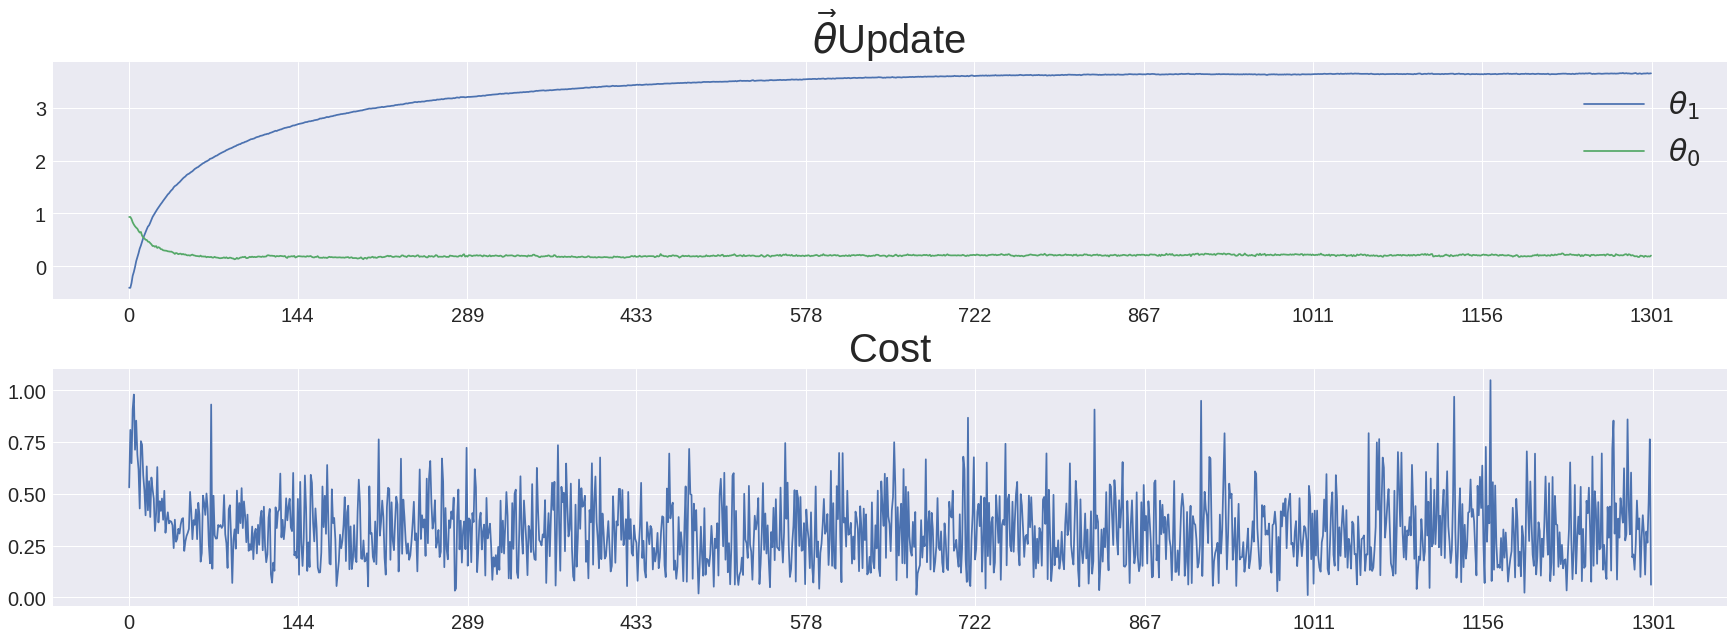

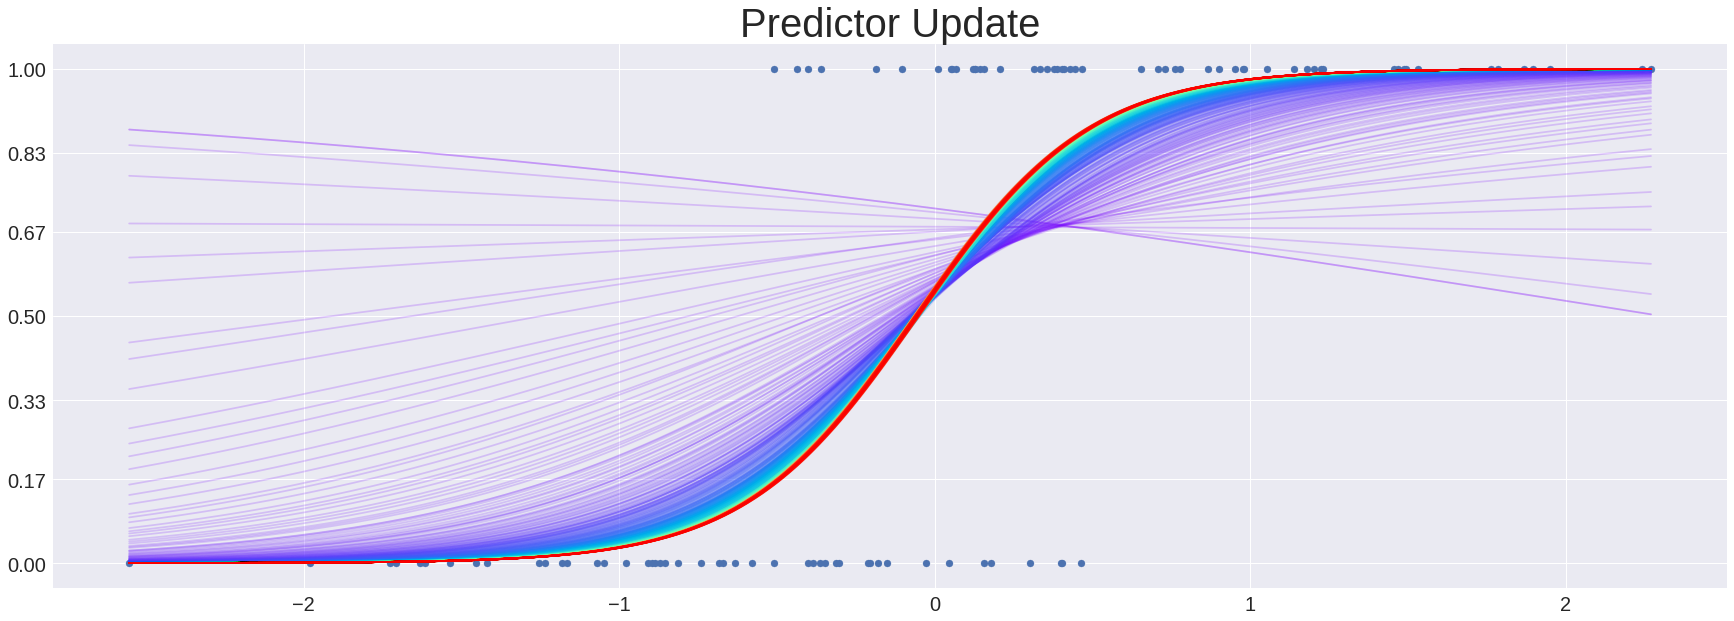

In [11]:
for epoch in range(epochs):
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):
        batch = get_data_batch(data, batch_idx)
        X,Y =  batch[:,1], batch[:,-1]

        Pred = model.forward(X)
        J = BCE_Cost.forward(Y, Pred)

        dPred = BCE_Cost.backward()
        model.backward(dPred, lr)

        result_tracker()
result_visualizer()